# Image Loading and Preprocessing


在本教程中，我们将了解如何从本地文件或URL加载图像，然后您可以在其他教程或示例中使用这些文件。此外，我们将深入探讨将Caffe2与图像一起使用所需的预处理类型。

#### Mac OSx Prerequisites


如果您还没有安装这些Python模块，那么现在就需要这样做。
```
sudo pip install scikit-image scipy matplotlib
```

In [19]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import skimage
import skimage.io as io
import skimage.transform 
import sys
import numpy as np
import math
from matplotlib import pyplot
import matplotlib.image as mpimg
print("Required modules imported.")

Required modules imported.


## Test an Image


在下面的代码块中使用`IMAGE_LOCATION`来加载您想要测试的内容。只需更改注释标记即可完成每轮教程。通过这种方式，您将了解各种图像格式会发生什么变化，以及有关如何预处理它们的一些提示。如果要尝试自己的图像，请将其放在images文件夹中或使用远程URL。当您选择远程URL时，请找自己能够轻松获得的并尝试查找指向常见图像文件类型和扩展名的URL，而不是某些长标识符或查询字符串，这可能会影响下一步。

## Color Issues


从智能手机相机加载图像时，请记住可能会遇到颜色格式问题。下面我们将展示RGB和BGR之间的翻转如何影响图像的示例。如果图片格式搞错显然会使您的模型中的检测失效。确保您传递的图像数据是您认为的！

### Caffe Uses BGR Order

 
由于Caffe依赖OpenCV的传统支持以及opencv处理蓝绿红（BGR）顺序的图像而不是更常用的红-绿-蓝（RGB）顺序，Caffe2也是** BGR **顺序。从很多方面来说，这个决定从长远来看有助于您使用不同的计算机视觉实用程序和库，但它也可能是混乱的根源。

Text(0.5,1,u'OpenCV, Caffe2 = BGR')

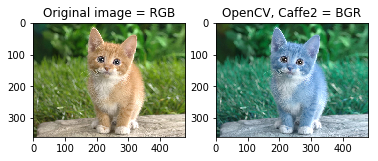

In [20]:
# You can load either local IMAGE_FILE or remote URL
# For Round 1 of this tutorial, try a local image.
IMAGE_LOCATION = 'images/cat.jpg'

# For Round 2 of this tutorial, try a URL image with a flower: 
# IMAGE_LOCATION = "https://cdn.pixabay.com/photo/2015/02/10/21/28/flower-631765_1280.jpg"
# IMAGE_LOCATION = "images/flower.jpg"

# For Round 3 of this tutorial, try another URL image with lots of people:
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/1/18/NASA_Astronaut_Group_15.jpg"
# IMAGE_LOCATION = "images/astronauts.jpg"

# For Round 4 of this tutorial, try a URL image with a portrait!
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/9/9a/Ducreux1.jpg"
# IMAGE_LOCATION = "images/Ducreux.jpg"

img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)

# test color reading
# show the original image
pyplot.figure()
pyplot.subplot(1,2,1)
pyplot.imshow(img)
pyplot.axis('on')
pyplot.title('Original image = RGB')

# show the image in BGR - just doing RGB->BGR temporarily for display
imgBGR = img[:, :, (2, 1, 0)]
#pyplot.figure()
pyplot.subplot(1,2,2)
pyplot.imshow(imgBGR)
pyplot.axis('on')
pyplot.title('OpenCV, Caffe2 = BGR')

正如您在上面的示例中所看到的，记住顺序的差异非常重要。在下面的代码块中，我们将拍摄图像并转换为BGR顺序，以便Caffe适当地处理它。

但等等，有更多的色彩乐趣......

### Caffe Prefers CHW Order

怎么办！？你问什么是CHW？那么，还有HWC！这两种格式都出现在图像处理中：

- H: Height
- W: Width
- C: Channel (as in color)

深入研究图像数据的存储方式是内存分配顺序。您可能已经注意到，当我们第一次加载图像时，我们强制它通过一些有趣的转换。这些是数据转换，让我们可以像使用立方体一样使用图像。我们看到的是在立方体的顶部，操纵下面的层可以改变我们所看到的。我们可以修补它的基本属性，如上所述，很容易交换颜色。

对于GPU处理，这是Caffe2擅长的，这个订单需要是CHW。对于CPU处理，此顺序通常为HWC。基本上，您将要使用CHW并确保步骤包含在图像管道（image pipeline）中。将RGB调整为BGR，将其封装为此“C”有效负载，然后调整HWC，“C”是您刚刚切换的相同颜色。


你可能会问为什么！原因指向cuDNN，这有助于加速GPU的处理。它只使用CHW，我们总结说它更快。


鉴于这两种转变，您可能认为这已足够，但事实并非如此。我们仍然需要调整大小和、或裁剪（resize and/or crop），并可能会查看方向（旋转）和镜像（orientation (rotation) and mirroring）等内容。

## Rotation and Mirroring（旋转和镜像）


本主题通常保留用于来自智能手机的图像。一般来说，手机拍摄的照片很棒，但在拍摄照片的方式以及应该采用的方向方面做得非常糟糕。然后是用户用手机的相机在阳光下做所有事情，让他们做的事情是设计师永远不会做的事情预期。**相机**-对，因为手机通常有两个相机，这两个相机在像素数和纵横比上都采用不同大小的图片，不仅如此，它们有时会将它们镜像，有时它们会以纵向和横向模式拍摄，有时也会他们懒得知道他们在哪个模式。



在许多方面，这是您需要在管道（in your pipeline）中评估的第一件事，然后查看大小调整（sizing）（如下所述），然后找出颜色情况（the color situation）。如果你正在为iOS开发，那么你很幸运，它会相对容易。如果你是一个超级黑客向导开发人员，带有铅衬短裤并为Android开发，那么至少你有铅衬短裤。


Android市场的变化是美妙而可怕的。在理想的世界中，您可以依赖来自任何相机的图片中的EXIF数据并使用它来决定方向和镜像，并且您将拥有一个简单的案例功能来处理您的转换。没有这样的运气，但你并不孤单。许多人来到你面前，为你而受苦。

Text(0.5,1,u'Mirror image')

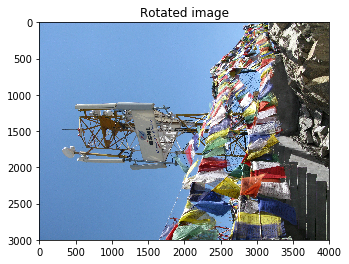

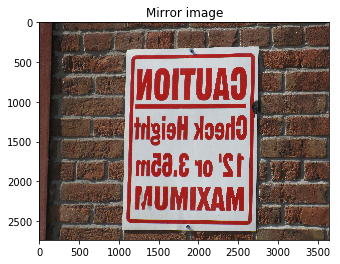

In [21]:
# Image came in sideways - it should be a portait image!
# How you detect this depends on the platform
# Could be a flag from the camera object
# Could be in the EXIF data
# ROTATED_IMAGE = "https://upload.wikimedia.org/wikipedia/commons/8/87/Cell_Phone_Tower_in_Ladakh_India_with_Buddhist_Prayer_Flags.jpg"
ROTATED_IMAGE = "images/cell-tower.jpg"
imgRotated = skimage.img_as_float(skimage.io.imread(ROTATED_IMAGE)).astype(np.float32)
pyplot.figure()
pyplot.imshow(imgRotated)
pyplot.axis('on')
pyplot.title('Rotated image')

# Image came in flipped or mirrored - text is backwards!
# Again detection depends on the platform
# This one is intended to be read by drivers in their rear-view mirror
# MIRROR_IMAGE = "https://upload.wikimedia.org/wikipedia/commons/2/27/Mirror_image_sign_to_be_read_by_drivers_who_are_backing_up_-b.JPG"
MIRROR_IMAGE = "images/mirror-image.jpg"
imgMirror = skimage.img_as_float(skimage.io.imread(MIRROR_IMAGE)).astype(np.float32)
pyplot.figure()
pyplot.imshow(imgMirror)
pyplot.axis('on')
pyplot.title('Mirror image')



所以你可以看到我们遇到了一些问题。如果我们正在探测地点，地标或物体（detecting places, landmarks, or objects），那么侧身的蜂窝塔就不好了。如果我们检测文本（detecting text）并进行自动语言翻译（automatic language translation），那么图片中是镜像文本就不好了。但是，嘿，也许你想制作一个可以通过两种方式检测英语的模型。这将是非常棒的，但不适用于本教程！



让我们将这些图片变成Caffe2可测，我们周围的标准检测模型可以检测到。此外，这个小技巧可能会拯救你，例如，你真的必须检测蜂窝塔，但没有找到EXIF数据：那么你将循环每一次旋转，每次翻转，产生这张照片的许多衍生物并运行它们。当检测的置信度百分比足够高时，Bam !你找到了你需要的方向和隐藏其中的蜂窝塔。

无论如何，对于示例代码：

Text(0.5,1,u'Mirror image')

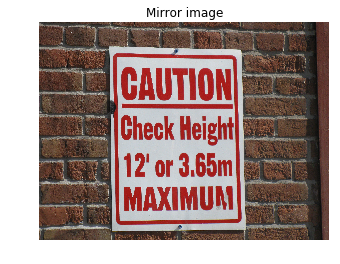

In [22]:
# Run me to flip the image back and forth
imgMirror = np.fliplr(imgMirror)
pyplot.figure()
pyplot.imshow(imgMirror)
pyplot.axis('off')
pyplot.title('Mirror image')

Text(0.5,1,u'Rotated image')

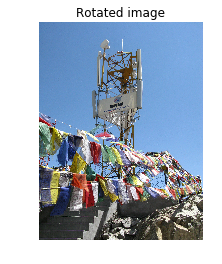

In [23]:
# Run me to rotate the image 90 degrees
imgRotated = np.rot90(imgRotated, 3)
pyplot.figure()
pyplot.imshow(imgRotated)
pyplot.axis('off')
pyplot.title('Rotated image')

## Sizing



预处理的一部分是调整大小。由于我们不会进入这里的原因，Caffe2管道（pipeline）中的图像应该是方形的。此外，为了提高性能，它们应调整到标准高度和宽度，通常小于原始来源。在下面的示例中，我们将调整为256 x 256像素，但您可能会注意到`input_height`和`input_width`设置为224 x 224，然后用于指定裁剪。这是几个基于图像的模型所期望的。他们接受了大小为224 x 224的图像训练，为了使模型能够正确识别您投射的可疑图像，这些图像也应该是224 x 224。

** 确保仔细检查您正在使用的model的输入数据尺寸（input size）！**

Original image's shape is 360x480
Model's input shape is 224x224
New image shape:(256, 256, 3)


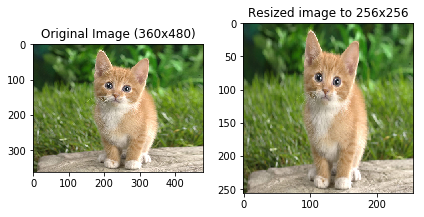

In [12]:
# Model is expecting 224 x 224, so resize/crop needed.
# First, let's resize the image to 256*256
orig_h, orig_w, _ = img.shape
print("Original image's shape is {}x{}".format(orig_h, orig_w))
input_height, input_width = 224, 224
print("Model's input shape is {}x{}".format(input_height, input_width))
img256 = skimage.transform.resize(img, (256, 256))

# Plot original and resized images for comparison
f, axarr = pyplot.subplots(1,2)
axarr[0].imshow(img)
axarr[0].set_title("Original Image (" + str(orig_h) + "x" + str(orig_w) + ")")
axarr[0].axis('on')
axarr[1].imshow(img256)
axarr[1].axis('on')
axarr[1].set_title('Resized image to 256x256')
pyplot.tight_layout()

print("New image shape:" + str(img256.shape))


请注意，调整大小会使图像失真一点。在处理过程中认识到resizing非常重要，因为它会对模型的结果产生影响。花和动物可能会有一点拉伸或挤压，但面部特征可能不会。

当原始图像的尺寸与所需尺寸不成比例时，可能会发生这种情况。在这个特定的例子中，最好只调整大小为224x224，而不是麻烦裁剪（cropping）。让我们尝试另一种重新调整图像和保持宽高比的策略。

### Rescaling（重新缩放）


如果你想象肖像（肖像）图像与风景（Landscape）图像，你就会知道有很多东西可以通过调整大小来搞砸。重新缩放假设您正在锁定宽高比以防止图像失真。在这种情况下，我们将图像缩小到与模型输入大小匹配的最短边。


在我们这里的示例中，模型大小为224 x 224.当您在1920x1080中查看显示器时，它的宽度比高度更长，如果将其缩小到224，则在用完之前就会超出高度宽度，所以......
- Landscape（风景）: limit resize by the height
- Portrait（肖像）: limit resize by the width

Original image shape:(360, 480, 3) and remember it should be in H, W, C!
Model's input shape is 224x224
Orginal aspect ratio: 1.33333333333
New image shape:(224, 298, 3) in HWC


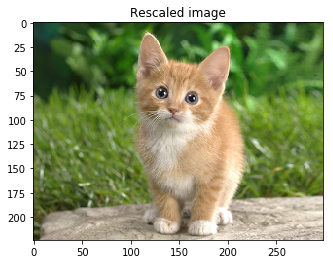

In [25]:
print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
print("Model's input shape is {}x{}".format(input_height, input_width))
aspect = img.shape[1]/float(img.shape[0])
print("Orginal aspect ratio: " + str(aspect))
if(aspect>1):
    # landscape orientation - wide image
    res = int(aspect * input_height)
    imgScaled = skimage.transform.resize(img, (input_height, res))
if(aspect<1):
    # portrait orientation - tall image
    res = int(input_width/aspect)
    imgScaled = skimage.transform.resize(img, (res, input_width))
if(aspect == 1):
    imgScaled = skimage.transform.resize(img, (input_height, input_width))
pyplot.figure()
pyplot.imshow(imgScaled)
pyplot.axis('on')
pyplot.title('Rescaled image')
print("New image shape:" + str(imgScaled.shape) + " in HWC")


此时，只有一个维度设置为模型输入所需的维度。我们仍然需要裁剪（crop）一边做一个正方形。

### Cropping（裁剪）



我们可以利用各种策略。事实上，我们可以倒退并决定做一个中心裁剪（center crop）。所以我们不是缩小到最小的，我们可以至少在一边，我们从中间拿出一大块。如果我们在没有缩放的情况下完成了这项操作，那么我们最终只能使用花朵踏板（flower pedal）的一部分，因此我们仍需要对图像进行一些调整。


下面我们将尝试一些裁剪（cropping）策略：
1. Just grab the exact dimensions you need from the middle!只需从中间抓住您需要的确切尺寸！
2. Resize to a square that's pretty close then grab from the middle.调整到一个非常接近的正方形然后从中间抓取。
3. Use the rescaled image and grab the middle.使用重新缩放的图像并抓住中间。

Original image shape:(360, 480, 3) and remember it should be in H, W, C!


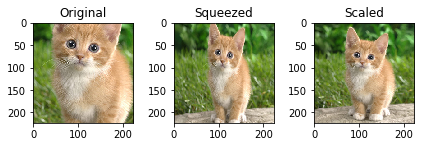

In [26]:
# Compare the images and cropping strategies
# Try a center crop on the original for giggles
print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]
# yes, the function above should match resize and take a tuple...

pyplot.figure()
# Original image
imgCenter = crop_center(img,224,224)
pyplot.subplot(1,3,1)
pyplot.imshow(imgCenter)
pyplot.axis('on')
pyplot.title('Original')

# Now let's see what this does on the distorted image
img256Center = crop_center(img256,224,224)
pyplot.subplot(1,3,2)
pyplot.imshow(img256Center)
pyplot.axis('on')
pyplot.title('Squeezed')

# Scaled image
imgScaledCenter = crop_center(imgScaled,224,224)
pyplot.subplot(1,3,3)
pyplot.imshow(imgScaledCenter)
pyplot.axis('on')
pyplot.title('Scaled')

pyplot.tight_layout()


你可以看到，除了可能是最后一个之外，它没有那么好用。中间的一个也可能没问题，但是在你尝试模型并测试很多候选图像之前你不会知道。
在这一点上，我们可以看看我们的差异，将其分成两半并从每一侧移除一些像素。然而，这确实有一个缺点，因为偏离中心的主题会被削减。

 
如果您现在已经运行过几次本教程并且在第3轮，那么您会发现一个非常大的问题。你错过了宇航员！你仍然可以看到第二轮花的问题。裁剪后缺少的东西可能会导致问题。可以这样想：如果您不知道您正在使用的模型是如何准备的，那么您不知道如何使图像符合要求，因此请注意测试结果！如果模型使用了很多不同的宽高比图像并且只是挤压它们以符合正方形那么很有可能随着时间的推移和大量的样本它“学会”了什么东西看起来像挤压并且可以匹配。但是，如果您正在寻找面部特征和地标等细节，或者任何图像中真正细致入微的元素，这可能是危险且容易出错的。

#### Further Strategies（进一步战略）?

另一种策略是使用真实数据重新调整到最佳尺寸，然后使用您可以在模型中安全忽略的信息填充图像的其余部分。因为你在这里经历了足够的经验，我们将把它保存到另一个教程中！

### Upscaling（倍增）

当您想要运行的图像“微小”时，您会怎么做？在我们的例子中，我们一直在准备输入图像，规格为224x224。请考虑下面的128x128图像。
![cells at 128x128](images/Cellsx128.png)

现在我们不是在讨论超分辨率或CSI效应（CSI-effect），我们可以拍摄模糊的ATM照片，并将纹身识别为perp的脖子。尽管如此，深度学习已经提供了[一些进展](https://github.com/david-gpu/srez)，如果你及时阅读（在2017/3/1日之前），去[看看这个](https://developer.nvidia.com/zoom-enhance-magic-image-upscaling-using-deep-learning)。我们想要做的很简单，但是，就像裁剪一样，它确实有各种你应该考虑的策略。


最基本的方法是从一个小方块到一个更大的方块，并使用defauls skimage为您提供。这个`resize`方法默认插值顺序参数为1，如果你甚至关心，它恰好是双线性的，但值得一提的是因为这些可能是稍后需要修改问题的微调旋钮，例如奇怪的视觉伪像，可以在升级图像中引入。

Original image shape:  (128, 128, 4)
Upscaled image shape:  (224, 224, 4)


Text(0.5,1,u'224x224')

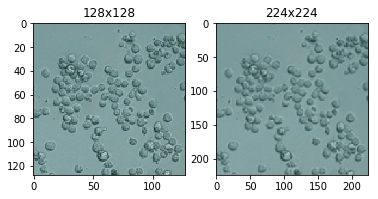

In [27]:
imgTiny = "images/Cellsx128.png"
imgTiny = skimage.img_as_float(skimage.io.imread(imgTiny)).astype(np.float32)
print("Original image shape: ", imgTiny.shape)
imgTiny224 = skimage.transform.resize(imgTiny, (224, 224))
print("Upscaled image shape: ", imgTiny224.shape)
# Plot original
pyplot.figure()
pyplot.subplot(1, 2, 1)
pyplot.imshow(imgTiny)
pyplot.axis('on')
pyplot.title('128x128')
# Plot upscaled
pyplot.subplot(1, 2, 2)
pyplot.imshow(imgTiny224)
pyplot.axis('on')
pyplot.title('224x224')

很棒，它有效！您可以在形状输出中看到（128,128,4）并且您已收到（224,224,4）。等一下！ 4？到目前为止，在每个例子中，形状的最后一个值是3！当我们使用png文件时，我们进入了一个新的现实;一个可以透明的地方。第4个值描述不透明度或透明度，具体取决于您是否为玻璃半空类型。无论如何，我们可以处理它，但要注意这个数字。


重要的是要知道，在我们对图像进行进一步操作之前，它是数据顺序(data order)，以及它的整体有效负载(overall payload)，如果您以当前格式对图像进行简单的重采样，则可能会弄乱数据和图像。请记住，它目前是一个数据立方体(a cube of data)，现在还有更多的数据，而不仅仅是红色，绿色和蓝色（以及不透明度(opacity)）。根据您决定调整大小的时间，您必须考虑额外的数据。


我们打破一下吧！将图像切换为CHW后尝试升级图像。

Image shape before HWC --> CHW conversion:  (128, 128, 4)
Image shape after HWC --> CHW conversion:  (4, 128, 128)
Image shape after resize:  (224, 224, 128)
Here come bad things!


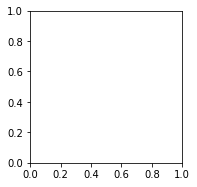

In [28]:
imgTiny = "images/Cellsx128.png"
imgTiny = skimage.img_as_float(skimage.io.imread(imgTiny)).astype(np.float32)
print("Image shape before HWC --> CHW conversion: ", imgTiny.shape)
# swapping the axes to go from HWC to CHW
# uncomment the next line and run this block!
imgTiny = imgTiny.swapaxes(1, 2).swapaxes(0, 1)
print("Image shape after HWC --> CHW conversion: ", imgTiny.shape)
imgTiny224 = skimage.transform.resize(imgTiny, (224, 224))
print("Image shape after resize: ", imgTiny224.shape)
# we know this is going to go wrong, so...
try:
    # Plot original
    pyplot.figure()
    pyplot.subplot(1, 2, 1)
    pyplot.imshow(imgTiny)
    pyplot.axis('on')
    pyplot.title('128x128')
except:
    print("Here come bad things!")
    # hands up if you want to see the error (uncomment next line)
    #raise 

失败了吧？如果你让上面的代码块交换轴，然后调整图像大小，你会看到这个输出：

`Image shape after resize:  (224, 224, 128)`


现在你有128个你应该还有4。糟糕,让我们在下面的代码块中恢复并尝试其他方法。我们将展示一个示例，其中图像小于您的输入规范，而不是正方形。就像它可能来自一个只能在矩形带中拍摄图像的新显微镜。

Slice image shape:  (56, 128, 4)
Upscaled slice image shape:  (224, 224, 4)


Text(0.5,1,u'224x224')

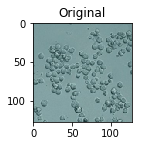

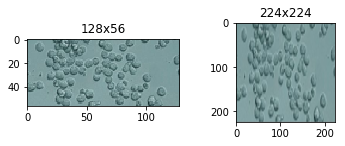

In [29]:
imgTiny = "images/Cellsx128.png"
imgTiny = skimage.img_as_float(skimage.io.imread(imgTiny)).astype(np.float32)
imgTinySlice = crop_center(imgTiny, 128, 56)
# Plot original
pyplot.figure()
pyplot.subplot(2, 1, 1)
pyplot.imshow(imgTiny)
pyplot.axis('on')
pyplot.title('Original')
# Plot slice
pyplot.figure()
pyplot.subplot(2, 2, 1)
pyplot.imshow(imgTinySlice)
pyplot.axis('on')
pyplot.title('128x56')
# Upscale?
print("Slice image shape: ", imgTinySlice.shape)
imgTiny224 = skimage.transform.resize(imgTinySlice, (224, 224))
print("Upscaled slice image shape: ", imgTiny224.shape)
# Plot upscaled
pyplot.subplot(2, 2, 2)
pyplot.imshow(imgTiny224)
pyplot.axis('on')
pyplot.title('224x224')


好吧，这对于upscaling如何失败的一个例子来说有点紧张。得到它？伸展（Stretch）？然而，这可能是一种生死攸关的失败。如果正常细胞是圆形的并且患病的细胞被拉长并弯曲怎么办？镰状细胞性贫血例如：
![sickle cells example](images/sickle-cells.jpg)

在这种情况下，你做什么？这实际上取决于模型以及它是如何训练的。在某些情况下，可以将图像的其余部分填充为白色，或者可能是黑色，或者可能是噪声，或者甚至可以使用png和透明度并为图像设置遮罩，以便模型忽略透明区域。看看你能想出多少有趣的事情，你也可以取得医学上的突破！


让我们继续我们已经提到的最后一步，即将图像输入调整为BGR顺序。Caffe2还有另一个功能，即`batch term`。我们已经谈过CHW了。对于NCHW中的图像数量，这是N.

### Final Preprocessing and the Batch Term（最终预处理和批处理期限）


在下面的最后一步中，我们将把图像的数据顺序切换到BGR，将其填入Color列，然后对列进行重新排序以进行GPU处理（HCW - > CHW），然后向图像添加第四维（N）跟踪图像的数量。从理论上讲，您可以继续为数据添加维度，但Caffe2需要这个维度，因为它会向Caffe传达此批次中预期的图像数量。我们将其设置为一（1）表示此批次中只有一张图像进入Caffe。请注意，在我们检查`img.shape`时的最终输出中，顺序是完全不同的。我们为图像数添加了N，并改变了顺序：`N，C，H，W`

Image shape before HWC --> CHW conversion:  (224, 224, 3)
Image shape after HWC --> CHW conversion:  (3, 224, 224)
Image shape after BGR conversion:  (3, 224, 224)
Final input shape is: (1, 3, 224, 224)


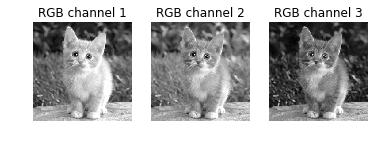

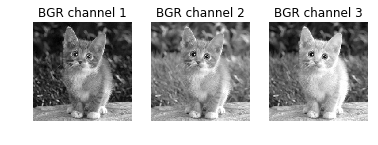

In [30]:
# This next line helps with being able to rerun this section
# if you want to try the outputs of the different crop strategies above
# swap out imgScaled with img (original) or img256 (squeezed)
imgCropped = crop_center(imgScaled,224,224)
print("Image shape before HWC --> CHW conversion: ", imgCropped.shape)
# (1) Since Caffe expects CHW order and the current image is HWC,
#     we will need to change the order.
imgCropped = imgCropped.swapaxes(1, 2).swapaxes(0, 1)
print("Image shape after HWC --> CHW conversion: ", imgCropped.shape)

pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(imgCropped[i], cmap=pyplot.cm.gray)
    pyplot.axis('off')
    pyplot.title('RGB channel %d' % (i+1))

# (2) Caffe uses a BGR order due to legacy OpenCV issues, so we
#     will change RGB to BGR.
imgCropped = imgCropped[(2, 1, 0), :, :]
print("Image shape after BGR conversion: ", imgCropped.shape)

# for discussion later - not helpful at this point
# (3) (Optional) We will subtract the mean image. Note that skimage loads
#     image in the [0, 1] range so we multiply the pixel values
#     first to get them into [0, 255].
#mean_file = os.path.join(CAFFE_ROOT, 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
#mean = np.load(mean_file).mean(1).mean(1)
#img = img * 255 - mean[:, np.newaxis, np.newaxis]

pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(imgCropped[i], cmap=pyplot.cm.gray)
    pyplot.axis('off')
    pyplot.title('BGR channel %d' % (i+1))
# (4) Finally, since caffe2 expect the input to have a batch term
#     so we can feed in multiple images, we will simply prepend a
#     batch dimension of size 1. Also, we will make sure image is
#     of type np.float32.
imgCropped = imgCropped[np.newaxis, :, :, :].astype(np.float32)
print('Final input shape is:', imgCropped.shape)

在上面的输出中，您应该注意这些更改：
1. HWC到CHW之前和之后的变化。3，这是移动到开头的颜色通道的数量。
2. 在上面的图片中，您可以看到颜色顺序也已切换。 RGB成为BGR。蓝色和红色切换位置。
3. 最终的输入形状，意味着对图像的最后一次更改是将批处理字段添加到开头，所以现在你有（1,3,224,224）：
    - 1 image in the batch, 
    - 3 color channels (in BGR), 
    - 224 height, 
    - 224 width.